In [837]:
import warnings
warnings.filterwarnings('ignore')
from plotnine import *

from sklearn.decomposition import PCA
import pandas as pd
from sklearn.linear_model import LogisticRegression
from sklearn.preprocessing import StandardScaler
from sklearn.linear_model import LinearRegression, Ridge, Lasso, ElasticNet
from sklearn.preprocessing import StandardScaler #Z-score variables
from sklearn.metrics import r2_score, mean_squared_error, mean_absolute_error, silhouette_score, accuracy_score, confusion_matrix
from sklearn.model_selection import train_test_split # simple TT split cv
from sklearn.mixture import GaussianMixture
from sklearn.tree import DecisionTreeClassifier # Decision Tree
from sklearn.decomposition import PCA
from sklearn.cluster import KMeans
from adjustText import adjust_text

import openpyxl
import matplotlib as plt
import numpy as np

In [846]:
#clustering PA Efficiency
data = pd.read_csv("/Users/jacksonthomas/Desktop/Orleans Firebirds/Reports/Stats/Cape Cod 2021 TB Tracker.csv")
data = data.fillna(0)
data

,Player,Team,AB,1B,2B,3B,HR,TB/AB,BB/K
0,C Bender,BOR,33,7,1.0,0.0,1.0,0.39,0.20
1,K. Fedko,BOR,50,11,0.0,0.0,0.0,0.22,0.21
2,D. Rushing,BOR,118,22,9.0,0.0,6.0,0.54,0.55
3,C. Knapczyk,BOR,109,26,8.0,1.0,0.0,0.41,0.81
4,C. Wallace,BOR,62,11,5.0,0.0,2.0,0.47,0.32
...,...,...,...,...,...,...,...,...,...
150,D. Bowser,YD,72,11,2.0,0.0,1.0,0.26,0.39
151,Z. Lew,YD,80,10,2.0,0.0,0.0,0.18,0.38
152,C. Hunter,YD,56,5,4.0,0.0,1.0,0.30,0.30
153,D. Keegan,YD,43,8,0.0,0.0,5.0,0.65,0.42


In [849]:
data = data[data["AB"] >=28]

In [850]:
#z-score variables
predictors = ["TB/AB" , "BB/K"]
X = data[predictors]
z = StandardScaler()
zScored = z.fit_transform(X)
data[predictors] = zScored
data.head()
data

,Player,Team,AB,1B,2B,3B,HR,TB/AB,BB/K
0,C Bender,BOR,33,7,1.0,0.0,1.0,0.271853,-0.768008
1,K. Fedko,BOR,50,11,0.0,0.0,0.0,-1.148005,-0.735176
2,D. Rushing,BOR,118,22,9.0,0.0,6.0,1.524669,0.381107
3,C. Knapczyk,BOR,109,26,8.0,1.0,0.0,0.438895,1.234736
4,C. Wallace,BOR,62,11,5.0,0.0,2.0,0.940022,-0.374026
...,...,...,...,...,...,...,...,...,...
150,D. Bowser,YD,72,11,2.0,0.0,1.0,-0.813921,-0.144203
151,Z. Lew,YD,80,10,2.0,0.0,0.0,-1.482090,-0.177035
152,C. Hunter,YD,56,5,4.0,0.0,1.0,-0.479837,-0.439690
153,D. Keegan,YD,43,8,0.0,0.0,5.0,2.443401,-0.045707


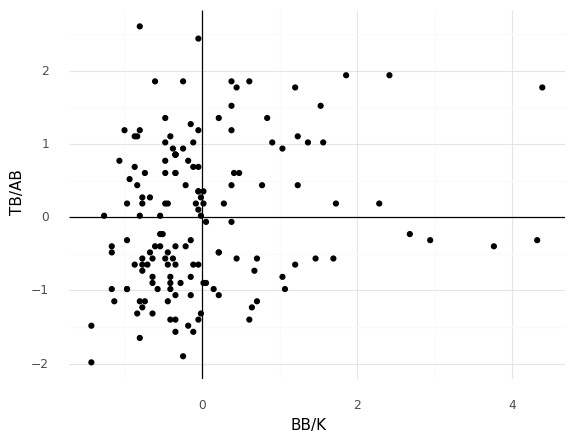

<ggplot: (8786843970964)>

In [851]:
#put graph here to identify spread for clustering
(ggplot(data, aes(x = "BB/K", y = "TB/AB")) + 
geom_point() + 
geom_hline(yintercept = 0) + 
geom_vline(xintercept = 0) +
theme_minimal())

In [852]:
#Conditional assignments
conditions = [(data["TB/AB"] <= 0.5) & (data["TB/AB"] >= -0.5) & (data["BB/K"] <= 0.5) & (data["BB/K"] >= -0.5),
             (data["TB/AB"] < 0) & (data["BB/K"] < 0),
             (data["TB/AB"] > 0) & (data["BB/K"] > 0), 
             (data["TB/AB"] > 0) & (data["BB/K"] < 0), 
             (data["TB/AB"] < 0) & (data["BB/K"] > 0)]

values = ["AVG", "-AVG", "ELITE", "HIT", "Eye"]
data["Profile"] = np.select(conditions, values)
data.head()

BBKmax = data["BB/K"].max()
BBKmin = data["BB/K"].min()
TBABmax = data["TB/AB"].max()
TBABmin = data["TB/AB"].min()

In [853]:
#too see all values/ cluster tiers in the column
unique = data["Profile"].unique()
print(sorted(unique))

['-AVG', 'AVG', 'ELITE', 'Eye', 'HIT']


In [854]:
(ggplot(data, aes(x = "BB/K", y = "TB/AB", color = "Profile")) + 
geom_hline(yintercept = 0, linetype = "dashed") + 
geom_vline(xintercept = 0, linetype = "dashed") +
# geom_vline(xintercept = 0.5) + 
# geom_vline(xintercept = -0.5) + 
# geom_hline(yintercept = 0.5) + 
# geom_hline(yintercept = -0.5) + 
geom_point() + 
theme_minimal() + 
xlim(BBKmin, BBKmax) + 
ylim(TBABmin, TBABmax) + 
ggtitle("Plate Appearance Efficiency Profile"))

data.head()

,Player,Team,AB,1B,2B,3B,HR,TB/AB,BB/K,Profile
0,C Bender,BOR,33,7,1.0,0.0,1.0,0.271853,-0.768008,HIT
1,K. Fedko,BOR,50,11,0.0,0.0,0.0,-1.148005,-0.735176,-AVG
2,D. Rushing,BOR,118,22,9.0,0.0,6.0,1.524669,0.381107,ELITE
3,C. Knapczyk,BOR,109,26,8.0,1.0,0.0,0.438895,1.234736,ELITE
4,C. Wallace,BOR,62,11,5.0,0.0,2.0,0.940022,-0.374026,HIT


In [856]:
profile = "PlateProfileFinal.csv"
data.to_csv(profile)

In [864]:
ORL = data[data["Team"] == "ORL"]
# ORL = ORL.drop([105,115,116,117,118], axis = 0)
ORL

Elite = data[data["Profile"] == "ELITE"]
Elite

,Player,Team,AB,1B,2B,3B,HR,TB/AB,BB/K,Profile
2,D. Rushing,BOR,118,22,9.0,0.0,6.0,1.524669,0.381107,ELITE
3,C. Knapczyk,BOR,109,26,8.0,1.0,0.0,0.438895,1.234736,ELITE
16,C. Davis,BRE,50,19,0.0,0.0,2.0,1.524669,1.530223,ELITE
17,C. Castillo,BRE,51,13,2.0,0.0,2.0,1.107064,1.234736,ELITE
18,Z. Neto,BRE,46,7,4.0,0.0,3.0,1.942275,1.858541,ELITE
19,J. Thompson,BRE,108,16,9.0,2.0,3.0,1.023543,1.563055,ELITE
56,J. Grady,COT,78,20,3.0,0.0,4.0,1.775232,0.446771,ELITE
57,E. Brown,COT,88,25,3.0,0.0,5.0,1.858753,0.381107,ELITE
58,N. Martorella,COT,46,14,4.0,0.0,1.0,1.775232,4.386596,ELITE
59,L. Gold,COT,86,13,4.0,0.0,6.0,1.357627,0.216948,ELITE


In [859]:
#too see all values/ cluster tiers in the column
uniqueORL = ORL["Profile"].unique()
print(sorted(uniqueORL))

['-AVG', 'AVG', 'ELITE', 'Eye', 'HIT']


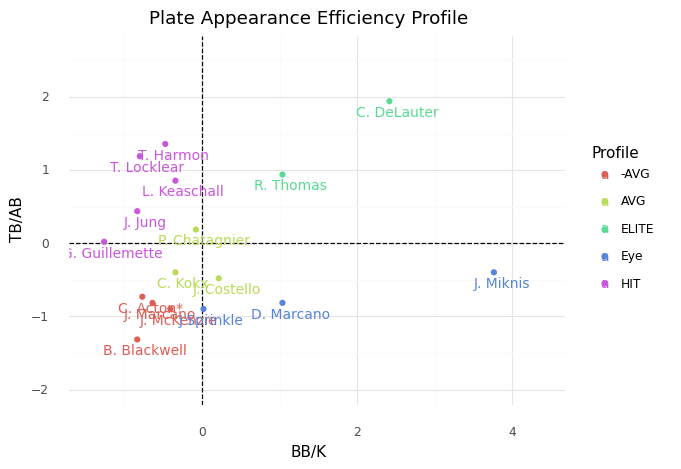

<ggplot: (8786845386710)>

In [860]:
(ggplot(ORL, aes(x = "BB/K", y = "TB/AB", color = "Profile")) + 
geom_hline(yintercept = 0, linetype = "dashed") + 
geom_vline(xintercept = 0, linetype = "dashed") +
# geom_vline(xintercept = 0.5) + 
# geom_vline(xintercept = -0.5) + 
# geom_hline(yintercept = 0.5) + 
# geom_hline(yintercept = -0.5) + 
geom_point() + 
geom_text(aes(label=ORL["Player"]),nudge_x = 0.1 , nudge_y = -0.15, size = 10) +
xlim(BBKmin, BBKmax) + 
ylim(TBABmin, TBABmax) + 
theme_minimal() + 
ggtitle("Plate Appearance Efficiency Profile"))